<a href="https://colab.research.google.com/github/yzihan/Generative-AI/blob/main/Exploring_the_Generative_Landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook goes along with a talk. Before we get to the code, I did promise some links for extra resources for those wanting to dive deeper. Come back to these later - for now skip to the fun bits!

I want to learn:
- Applying DL to practical problems like image recognition: 
    - [Practical Deep Learning for Coders](https://course.fast.ai/) is my favourite top-down intro. And a more in-depth part 2 covering some diffusion model-related ideas is starting in a few weeks.
- Deep Learning Foundations:
  - I like the [neuromatch deep learning content](https://deeplearning.neuromatch.io/tutorials/intro.html)
- AI art stuff - more like what you covered in the talk and in this notebook:
  - I ran a course on this, the notebooks and videos are up [here](https://github.com/johnowhitaker/aiaiart) and cover pytorch basics, style transfer, AEs and GANs, transformers for image sequence modelling, diffusion models, neural cellular automata and more. 
  - I'm working on a new course going into more depth which should be done by November - https://johnowhitaker.github.io/tglcourse/
- I want to play with Stable Diffusion
  - I wrote a notebook to cover all the components and ways you can hack them into doing fun new things: [Grokking Stable Diffusion](https://colab.research.google.com/drive/1dlgggNa5Mz8sEAGU0wFCHhGLFooW_pf1?usp=sharing) - with a bit of fiddling you should be able to use any of the loss functions later in this notebook to guide SD's generation ;)
  - There is also a [followup on 'textual inversion'](https://colab.research.google.com/drive/1RTHDzE-otzmZOuy8w1WEOxmn9pNcEz3u?usp=sharing) showing how to add in new concepts to SD's vocabulary and linking to resources for traiing your own.
- Can I train a GAN?
  - [This](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) is an introductory tutorial from pytorch on training a simple GAN. But GAN training is fiddly and temperamental - you might be better off starting from an existing implementation rather than trying to DIY it.
  - [Here's a script](https://github.com/huggingface/community-events/tree/main/huggan/pytorch/lightweight_gan) that should do the job (won't explain how GANs work but if you just want to feed in images it should just work). You can also google around for stylegan3, lightweightGAN and friends as there are a number of different tutorials on feeding in your own dataset and generating with that.
- What about the cool animations and things? 
  - There are community-made tools like [Deforum](https://deforum.github.io/) which give a lot of ways to control how images/animations are generated, you may enjoy digging into one and learning what the different settings do.
- What about those SOTA models you mentioned?
  - Search around for: imagen, parti, dalle-mini (now craiyon), dalle-2 and stable diffusion - each have fancy websites showcasing the models. 
- What about that 'old-school' VQGAN+CLIP stuff from way back in 2021? 
  - https://colab.research.google.com/drive/1peZ98vBihDD9A1v7JdH5VvHDUuW5tcRK?usp=sharing is a good notebook made by a friend of mine, using multiple CLIP models together and adding lots of extra tricks. 
- How do I keep up with this field?
  - Two Minute Papers, AI Coffee Break, Yannic Kilcher etc on YouTube
  - Follow https://twitter.com/_akhaliq on Twitter and then from there any authors or researchers doing cool things
  - multimodal.art run by a friend of mine links lots of resources, and has a tool (Mindseye) for running some of these models through a nice interface
Those should keep you busy for a bit, but if you have questions around a specific topic feel free to reach out to me - I'm @johnowhitaker on twitter and so on. For now, let's make some pretty pictures!


# Fun with Generators and Losses

We spoke about how deep learning relies heavily on one key idea: optimization:



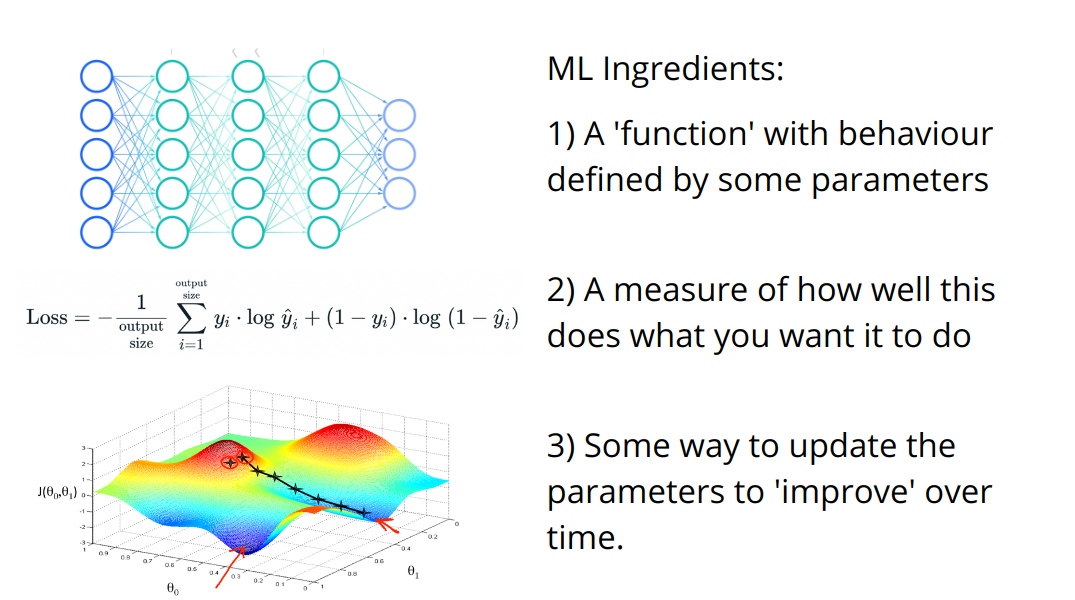

We're going to apply this mindset to the task of creating imagery in creative ways. To this end, we'll explore a number of different 'generators' (each of which create an image from some set of parameters) and a number of 'losses' (which try to measure how 'good' the generated images are by some measure). And then we'll play with combining different generators and losses to achieve different outputs. 

These will be introduced one by one, but I've tried to make them as interchangeable as possible so that you can swap in or combine any of these building blocks for any of the demos. And at the end there's a template for you to build your own final custom image generation tool and some hints for ideas to explore.

NB: If you want to use code from here in other projects just be careful - there are assumptions like 'all images are square' and 'all images come in a batch size 1' which might trip you up in more general use! I threw this together so that we can start having fun as fast as possible, so tradeoffs were made ;)

## Setup

In [1]:
!pip install -q imstack open_clip_torch siren-pytorch

     |████████████████████████████████| 1.4 MB 35.6 MB/s 
     |████████████████████████████████| 120 kB 68.3 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from matplotlib import pyplot as plt
from imstack.core import ImStack
from siren_pytorch import Sine, Siren, SirenNet, SirenWrapper
import open_clip
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import torchvision.models as models

In [3]:
# A lot of this will be doable on CPU but slow enough that GPU is preferrable 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Images as Tensors

We're going to represent an image as a tensor. There will be 3 channels (one for red, one for green and one for blue). 

We'll use the PIL library for reading and displaying images, which stores a 32px image as an array of shape [32, 32, 3] with values as integers from 0 to 255. 

We'll use PyTorch for most of our processing and optimization, which usually works with images in batches and has the batch dimension then the channel dimension as the first two dimensions. So a batch with one 32px image looks like this: [1, 3, 32, 32]. And we'll represent images as floats between 0 and 1.

To make life easy, here's how we switch from one to the other:

In [4]:
def pil_to_tensor(im):
    return torch.tensor(np.array(im.convert('RGB'))).permute(2, 0, 1).unsqueeze(0)/255.0

def tensor_to_pil(tensor_im):
    tensor_im = tensor_im.squeeze() # In case there is a batch dimension
    tensor_im = tensor_im.permute(1, 2, 0).detach().cpu() # Rearrange
    tensor_im = tensor_im.clip(0, 1)*255 # Note that we clip to (0, 1) 
    im_array = np.array(tensor_im).astype(np.uint8) # To numpy and int8
    im = Image.fromarray(im_array) # To PIL
    return im

## Our First Generator: Raw Pixels

What if we just optimize some pixels directly? An image is now represented by a number of parameters (the raw RGB values). This should be a good test case, and a chance to think about how we want to frame our `Generator`s going forward.

We need access to the parameters we can tweak, and a way to get the output. 

The best way I know of is to lean on the machinery PyTorch has for neural networks by inheriting from the `nn.Module` class. `nn.Parameter()` makes a tensor that automatically has gradient tracking set up, and all parameters created this way can be accessed with the `parameters()` function of our generator - which saves us needing to write that ourselves. 

We specify how we'd like to produce an output by defining the forward method. This lets us use our new object as a function - when we run `im = gen()` we're actually saying `im = gen.forward()`.

This might seem slightly overkill for this first example, but let's just check it out and see how it works:

Output shape: torch.Size([1, 3, 128, 128])


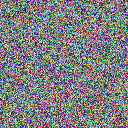

In [5]:
class PixelGenerator(nn.Module):
  """A tensor of shape [1, 3, size, size] to represent an image"""
  def __init__(self, size=256, init_image=None):
    super(PixelGenerator, self).__init__()
    self.im_array = nn.Parameter(torch.rand(1, 3, size, size))
    if init_image:
      self.im_array = nn.Parameter(pil_to_tensor(init_image.convert('RGB').resize((size, size))))
    
  def forward(self):
    return self.im_array

gen = PixelGenerator(128)
im = gen()
print(f'Output shape: {im.shape}')
tensor_to_pil(im)

Inspecting the parameters:

In [6]:
[p.shape for p in gen.parameters()]

[torch.Size([1, 3, 128, 128])]

There we go. Hopefully this will become useful in a second.

## Our First Loss: Mean Squared Error

We'll take the difference between an image and a target and square it. 

In [7]:
class MSELossToTarget(nn.Module):
  """ MSE between input and target, resizing if needed"""
  def __init__(self, target, size=256):
    super(MSELossToTarget, self).__init__()
    self.resize = T.Resize(size)
    self.target = self.resize(target) # resize target image to size

  def forward(self, input):
    input = self.resize(input) # set size (assumes square images)
    squared_error = (self.target - input)**2
    return squared_error.mean() # MSE

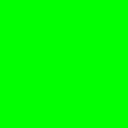

In [8]:
# Make a target image
target_image = torch.zeros(1, 3, 128, 128)
target_image[:,1] += 1 # Set the green channel to all ones
tensor_to_pil(target_image) # View it

In [9]:
# Create a loss function with this as the target
mse_loss = MSELossToTarget(target_image, size=128)

In [10]:
# Calculate the loss between this and the output of a generator
gen = PixelGenerator(128)
im = gen()
mse_loss(im) # We get a single measure with a way to trace the gradients backward

tensor(0.3353, grad_fn=<MeanBackward0>)

Q: Does that number make sense? What would the theoretical prediction be?

## Optimization

We want to tweak the parameters of our generator to make the loss (derived from the output) lower. Here's how we might do this in PyTorch:

In [11]:
# Set a target - here a green image as in the previous example
target_image = torch.zeros(1, 3, 128, 128)
target_image[:,1] += 1

# Make a loss function based on this target
mse_loss = MSELossToTarget(target_image, size=128)

# Set up our generator
gen = PixelGenerator(128)

# Set up an optimizer on the generators parameters
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-2)

One update:

In [12]:
# get the generator output
im = gen()

# find the loss
loss = mse_loss(im)

# Reset any stored gradients
optimizer.zero_grad()

# Calculate the gradients
loss.backward()

# Print the loss
print(loss.item()) 

# Update the generator parameters to reduce this loss
optimizer.step()

0.3345218598842621


Re-run the above cell a number of times, and use the following cell to see the current output:

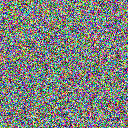

In [13]:
tensor_to_pil(gen()) # Generate and view an image

It gets greener over time - and the loss goes down. Hooray! Let's define some new generators and loss functions and then make a clean version of this optimization code that runs in a loop so we don't need to keep re-running a cell!

## Next Generator: ImStack

[ImStack is a library I made](https://johnowhitaker.github.io/imstack/) to represent images as a 'stack' of tensors of different sizes. The intuition here is that the lowest level can incorporate the large shapes and higher layers can capture fine details. When optimizing it can be useful to have a few parameters that have a large effect on the output - this can allow a cleaner gradient signal than if each pixel is independant.

This 'generator' just wraps an imstack. Note that it is the same as the pixel_generator except that we have a few extra possible arguments when creating one - for example we can initialise it with an input image (which we'll try soon).

Output shape: torch.Size([1, 3, 128, 128])
Parameter shapes: [torch.Size([3, 16, 16]), torch.Size([3, 32, 32]), torch.Size([3, 64, 64]), torch.Size([3, 128, 128])]


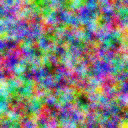

In [14]:
class ImStackGenerator(nn.Module):
  """An imstack to represent the image"""
  def __init__(self, size=256, n_layers=4, base_size=16, 
               layer_decay=0.7, init_image=None, scale=2):
    super(ImStackGenerator, self).__init__()
    self.imstack = ImStack(n_layers=n_layers, out_size=size, 
                           base_size=base_size, init_image=init_image, 
                           decay=layer_decay, scale=scale)
  
  def parameters(self): # How to access the learnable parameters
    return self.imstack.layers

  def forward(self):
    return self.imstack()

gen = ImStackGenerator(size=128, n_layers=4, base_size=16)
im = gen()
print(f'Output shape: {im.shape}')
print(f'Parameter shapes: {[p.shape for p in gen.parameters()]}')
tensor_to_pil(im)

Breaking down the layers in the stack:

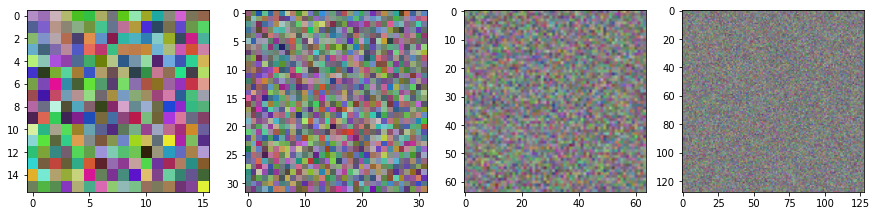

In [15]:
gen.imstack.plot_layers()

You can explore tweaking the base_size, n_layers and scale parameters to see how they affect the look of the initial (random) output and the total number of parameters.

## Style Transfer

Now we're going to try a classic application of pretrained models for artistic purposes: style transfer.

### Extracting features from a pretrained model

Pytorch has definitions of many common model architectures, and ways for loading pre-trained versions of them. In this case, we go for a small, older architecture called VGG16 trained on Imagenet (a dataset with >1M across 1k classes):

In [16]:
# Load a pretrained model:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)
vgg16.eval()
vgg16 = vgg16.features

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

To get the features, we run through the layers of the network, storing the outputs of some specified layers to be our featres:

In [17]:
# Extracting features from an image using this pretrained model:
def calc_vgg_features(imgs, use_layers=[1, 6, 11, 18, 25] ):
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].to(device)
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].to(device)
  x = (imgs-mean) / std
  b, c, h, w = x.shape
  features = [x.reshape(b, c, h*w)] # This reshape is for convenience later
  for i, layer in enumerate(vgg16[:max(use_layers)+1]):
    x = layer(x)
    if i in use_layers:
      b, c, h, w = x.shape
      features.append(x.reshape(b, c, h*w))
  return features

im = torch.rand(1, 3, 128, 128).to(device) # A random image for demo
feats = calc_vgg_features(im) # The activations of the specified layers
[f.shape for f in feats] # See the shapes of the returned features

[torch.Size([1, 3, 16384]),
 torch.Size([1, 64, 16384]),
 torch.Size([1, 128, 4096]),
 torch.Size([1, 256, 1024]),
 torch.Size([1, 512, 256]),
 torch.Size([1, 512, 64])]

You can see that from an input image we've got a bunch of features, one for each specified layer. We will use these for the style and content losses.

### Content Loss/Perceptual Loss

Remember our picture of a CNN:
![architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

We spoke about how early layers tend to capture edges and textures, while later layers aggregate these smaller features into more complex ones.

We can exploit this to try and focus on the broad 'content' of an image in a way that is robust to small changes to texture or color. To achieve this, we'll look only at activations from some deeper layers, in this case specified by `content_layers = [14, 19]`. You can print the network description and pick a few - see how changing them affects things!

In [18]:
# print(vgg16)

In [19]:
class ContentLossToTarget(nn.Module):
  """ Perceptual loss between input and target, resizing if needed, based on vgg16"""
  def __init__(self, target, size=128, content_layers = [14, 19]):
    super(ContentLossToTarget, self).__init__()
    self.resize = T.Resize(size)
    self.target = self.resize(target) # resize target image to size
    self.content_layers = content_layers
    with torch.no_grad():
      self.target_features = calc_vgg_features(self.target, use_layers = self.content_layers)

  def forward(self, input):
    input = self.resize(input) # set size (assumes square images)
    input_features = calc_vgg_features(input, use_layers = self.content_layers)
    l = 0
    # Run through all features and take l1 loss (mean error) between them
    for im_features, target_features in zip(input_features, self.target_features):
      l += nn.L1Loss()(im_features, target_features)
    return l/len(input_features)


content_loss = ContentLossToTarget(im)
content_loss(torch.rand(1, 3, 64, 64).to(device))

tensor(2.5217, device='cuda:0', grad_fn=<DivBackward0>)

We won't do a demo with just this loss, but feel free to experiment with it after you've seen a few of the upcoming demos. What happens when you start from random noise and optimise with just content loss to a target image - does it perfectly re-produce the target? What about intermediate stages - what kinds of feature appear first?

### Style Loss (OT version)

In a similar way, we want to capture style features. We mentioned that these will be better described by earlier layers, but there is a hitch: we want the styles of a target image, but not necessarily in the same places (otherwise we'd just get the whole picture!). So we need some way to remove the spatial component and just focus on the relative mix of colours, textures etc. 

There are a few approaches. Most tutorials will use a gram-matrix based approach (which works fine) but I recently heard of a potentially better approach using ideas of optimal transport via [this great video](https://www.youtube.com/watch?v=ZFYZFlY7lgI). We'll implement both and you can compare the two for yourself :)

Both give super large loss figures by default, so I've included a `scale_factor` argument to tame the values a little.

In [20]:
class OTStyleLossToTarget(nn.Module):
  """ Optimal Transport Loss for style comparison"""
  def __init__(self, target, size=128, style_layers = [1, 6, 11, 18, 25], scale_factor=1e-5):
    super(OTStyleLossToTarget, self).__init__()
    self.resize = T.Resize(size)
    self.target = self.resize(target) # resize target image to size
    self.style_layers = style_layers
    self.scale_factor = scale_factor # Defaults tend to be very large, we scale to make them easier to work with
    with torch.no_grad():
      self.target_features = calc_vgg_features(self.target, use_layers = self.style_layers)

  def project_sort(self, x, proj):
    return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

  def ot_loss(self, source, target, proj_n=32):
    ch, n = source.shape[-2:]
    projs = F.normalize(torch.randn(ch, proj_n).to(device), dim=0)
    source_proj = self.project_sort(source, projs)
    target_proj = self.project_sort(target, projs)
    target_interp = F.interpolate(target_proj, n, mode='nearest')
    return (source_proj-target_interp).square().sum()

  def forward(self, input):
    input = self.resize(input) # set size (assumes square images)
    input_features = calc_vgg_features(input, use_layers = self.style_layers)
    l = 0
    # Run through all features and take l1 loss (mean error) between them
    return sum(self.ot_loss(x, y) for x, y in zip(input_features, self.target_features)) * self.scale_factor


# Create and test a version of this loss
style_loss = OTStyleLossToTarget(im)
style_loss(torch.rand(1, 3, 64, 64).to(device))


tensor(12.6031, device='cuda:0', grad_fn=<MulBackward0>)

### Style Loss (Gramm Matrix Version)

In [21]:
class GramStyleLossToTarget(nn.Module):
  """ Gram matrix based style loss"""
  def __init__(self, target, size=128, style_layers = [1, 6, 11, 18, 25], scale_factor=0.1):
    super(GramStyleLossToTarget, self).__init__()
    self.resize = T.Resize(size)
    self.target = self.resize(target) # resize target image to size
    self.style_layers = style_layers
    self.scale_factor = scale_factor # Defaults tend to be very large, we scale to make them easier to work with
    with torch.no_grad():
      self.target_features = calc_vgg_features(self.target, use_layers = self.style_layers)

  def gram(self, x):
    b,c,hxw = x.size();
    h, w = int(hxw**0.5), int(hxw**0.5)
    x = x.view(b*c, -1);
    return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers


  def forward(self, input):
    input = self.resize(input) # set size (assumes square images)
    input_features = calc_vgg_features(input, use_layers = self.style_layers)
    loss = 0
    for im_features, target_features in zip(input_features, self.target_features):
      im_gram = self.gram(im_features)
      target_gram = self.gram(target_features)
      loss += F.mse_loss(im_gram, target_gram);
    return (loss/len(input_features)) * self.scale_factor

# Testing...
style_loss = GramStyleLossToTarget(im)
style_loss(torch.rand(1, 3, 64, 64).to(device))

tensor(11.1221, device='cuda:0', grad_fn=<MulBackward0>)

### Style Transfer Optimization Loop

Now for the fun bit. We're going to grab a couple of images and do an optimization loop.

Our loss will be a combination of the content loss w.r.t one image and a style loss w.r.t. a second style image.

By trying to balance both these objectives, we hope to end up with something that looks like one pic in the style of the other!

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  635k  100  635k    0     0  3876k      0 --:--:-- --:--:-- --:--:-- 3876k


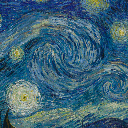

In [22]:
#@title style_image
!curl --output style.jpeg "https://i.pinimg.com/originals/c3/b4/38/c3b438401bab3e91b487cd30309224f7.gif"
style_image = Image.open('style.jpeg').resize((128, 128))
style_image

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58417  100 58417    0     0  1296k      0 --:--:-- --:--:-- --:--:-- 1296k


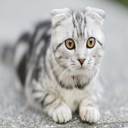

In [23]:
#@title content_image
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
content_image = Image.open('cat.jpeg').resize((128, 128))
content_image

### Optimization with multiple loss functions

  0%|          | 0/100 [00:00<?, ?it/s]

Step: 0: Loss: 17.47468376159668 (style_loss 17.474681854248047, content_loss 2.1511095837922767e-06)
Step: 25: Loss: 7.358654022216797 (style_loss 6.397679328918457, content_loss 0.9609746336936951)
Step: 50: Loss: 3.5947163105010986 (style_loss 2.3858530521392822, content_loss 1.2088632583618164)
Step: 75: Loss: 2.3021650314331055 (style_loss 0.9988356828689575, content_loss 1.3033292293548584)


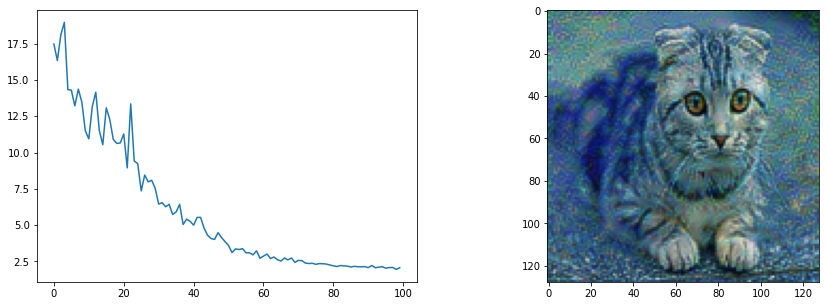

In [24]:
# Specify our loss functions:
style_loss_fn = OTStyleLossToTarget(pil_to_tensor(style_image).to(device))
# style_loss_fn = GramStyleLossToTarget(pil_to_tensor(style_image).to(device), size=128) # < alternative to try
content_loss_fn = ContentLossToTarget(pil_to_tensor(content_image).to(device))

# The generator (starting from the content image to speed things up, but you can change that!)
gen = ImStackGenerator(size=128, init_image=content_image).to(device)

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01, weight_decay=1e-6)

losses = [] # Keep track of our losses

# The actual loop:
for i in tqdm(range(100)):

  # Get the generator output
  output = gen()

  # # Calculate our loss
  style_loss = style_loss_fn(output) # Try: adding a scaling factor here to weight this more heavily
  content_loss = content_loss_fn(output)
  loss = style_loss + content_loss

  # Store the loss for later
  if i % 25 == 0:
    print(f'Step: {i}: Loss: {loss.detach().item()} (style_loss {style_loss.detach().item()}, content_loss {content_loss.detach().item()})' )
  losses.append(loss.detach().item())

  # Backpropagate the loss and use it to update the parameters
  optimizer.zero_grad() # Reset everything related to gradient calculations
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(losses)
axs[1].imshow(tensor_to_pil(gen()))

There we go! There are many things you could tweak here, but this hopefully shows the direction we're going. We express what we want with some loss function (in this case, a combination of style and content losses) and we slowly update the parameters of some generator using this loss. 

Write down a few ideas of what you want to try here. We're going to move straight on but you can always come back and play around with the code some more!

## New Generator: SIREN

[SIREN](https://arxiv.org/abs/2006.09661) represents an image in an interesting way, using a bunch of sinusiodal functions in a network. Anyone with some signals processing background can probably guess why this seems interesting. 

We'll wrap a library that does all the hard work for us, but just for curiosity's sake we can at least look at the building blocks, starting with the activation function:

In [25]:
# The activation (a wrapper around torch.sin):
act = Sine(1.)
coords = torch.randn(1, 2)
coords, act(coords) 

(tensor([[0.7079, 0.6608]]), tensor([[0.6502, 0.6138]]))

In [26]:
[p for p in act.parameters()]

[]

Given some inputs, it returns the sine of those. Not very exciting, and no parameters to learn.

Next, a single siren neuron:

In [27]:
# A SIREN layer
neuron = Siren(
    dim_in = 3,
    dim_out = 256
)
coords = torch.randn(1, 3)
neuron(coords).shape # (1, 256) - given three inputs it produces 256 outputs

torch.Size([1, 256])

In [28]:
[p.shape for p in neuron.parameters()]

[torch.Size([256, 3]), torch.Size([256])]

`dim_in` inputs are mapped to `dim_out` outputs. For each output we have one weight per input (256 x 3 params total in this case) and one bias (256 params here). The sum of the inputs plus the bias is fed through the Sine activation function to give the final output of the neuron.

A bunch of these combined in layers gives us a full SIREN network:

In [29]:
# A network with multiple layers:
net = SirenNet(
    dim_in = 2,                        # input dimension, ex. 2d coordinates
    dim_hidden = 64,                  # hidden dimension
    dim_out = 3,                       # output dimension, ex. rgb value
    num_layers = 5,                    # number of layers
    final_activation = nn.Sigmoid(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 30.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
)

coords = torch.randn(1, 2)
net(coords) # (1, 3) <- rgb value

tensor([[0.5898, 0.2667, 0.1707]], grad_fn=<SigmoidBackward0>)

In [30]:
# [p.shape for p in net.parameters()] # Uncomment to see the parameters of the different layers

We wrap one of these networks in a Generator:

Output shape: torch.Size([1, 3, 128, 128])
Parameter shapes: [torch.Size([64, 2]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([3, 64]), torch.Size([3])]


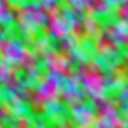

In [31]:
class SirenGenerator(nn.Module):
  """An SIREN network to represent the image"""
  def __init__(self, size=256, dim_hidden = 64, 
               num_layers = 5, w0_initial = 30.): 
    super(SirenGenerator, self).__init__()
    self.net = SirenNet(
        dim_in = 2,                        # input dimension, ex. 2d coordinates
        dim_hidden = dim_hidden,           # hidden dimension
        dim_out = 3,                       # output dimension, ex. rgb value
        num_layers = num_layers,           # number of layers
        final_activation = nn.Sigmoid(),   # activation of final layer (nn.Identity() for direct output)
        w0_initial = w0_initial            # different signals may require different omega_0 in the first layer - this is a hyperparameter
    )
    
    self.wrapper = SirenWrapper(
        self.net,
        image_width = size,
        image_height = size
    )
  
  def parameters(self): # How to access the learnable parameters
    return self.net.parameters()

  def forward(self):
    return self.wrapper()

gen = SirenGenerator(size=128)
im = gen()
print(f'Output shape: {im.shape}')
print(f'Parameter shapes: {[p.shape for p in gen.parameters()]}')
tensor_to_pil(im)

What is neat here is that the output of the network is a function of x and y coords - we can evalluate this function at any resolution! No nasty pixels here. We can also control the number of parameters by chanigng the number and size of the layers. For example, here are two versions and the corresponding total number of parameters:

In [32]:
# The default
gen = SirenGenerator()
print('Number of parameters in default net:', sum([p.numel() for p in gen.parameters()]))

# A smaller version
gen = SirenGenerator(dim_hidden=16, num_layers=3)
print('Number of parameters in mini version:', sum([p.numel() for p in gen.parameters()]))

Number of parameters in default net: 17027
Number of parameters in mini version: 643


You can 'fit' a siren network to an image using the MSELoss we made earlier. For example, here's a tiny net with 3 layers, hidden_dim=16, optimising towards the cat image:

  0%|          | 0/200 [00:00<?, ?it/s]

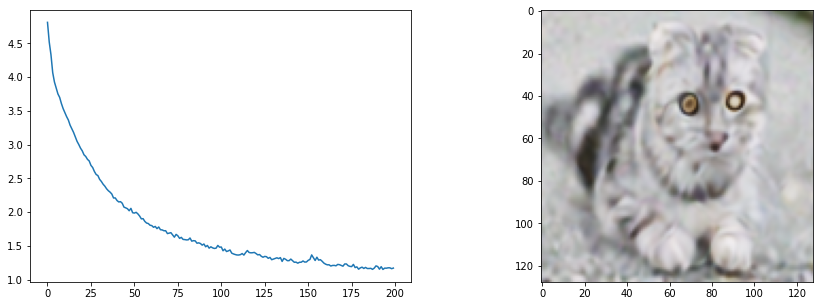

In [33]:
#@markdown **fitting an image with SIREN:**
mse_loss_fn = ContentLossToTarget(pil_to_tensor(content_image).to(device))
dim_hidden = 32 #@param
num_layers=4 #@param
gen = SirenGenerator(size=128, dim_hidden=dim_hidden, 
                     num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(gen.parameters(), lr=0.02, weight_decay=1e-6)
losses = []
for i in tqdm(range(200)):
  output = gen()
  loss = mse_loss_fn(output)
  losses.append(loss.detach().item())
  optimizer.zero_grad() # Reset everything related to gradient calculations
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(losses)
axs[1].imshow(tensor_to_pil(gen()))

Again, this is cool because we're representing this image with only ~3k parameters:

In [34]:
sum([p.numel() for p in gen.parameters()])

3363

Since these networks can be quite small, and run once per pixel at whatever size you want to generate, they are perfect for running as compute shaders. For eg, I trained a SIREN network with CLIP and turned it into a shader here: https://www.shadertoy.com/view/flGSDD (animating some of the parameters for a cool effect).


We can substitute this generator into the style transfer code to get a quick feel for what images made with the default settings look like:

  0%|          | 0/100 [00:00<?, ?it/s]

Step: 0: Loss: 12.331320762634277 (style_loss 7.821545600891113, content_loss 4.509775161743164)
Step: 25: Loss: 5.231120586395264 (style_loss 1.9726728200912476, content_loss 3.2584476470947266)
Step: 50: Loss: 3.6622731685638428 (style_loss 0.9961596131324768, content_loss 2.6661136150360107)
Step: 75: Loss: 2.924001455307007 (style_loss 0.5566990375518799, content_loss 2.367302417755127)


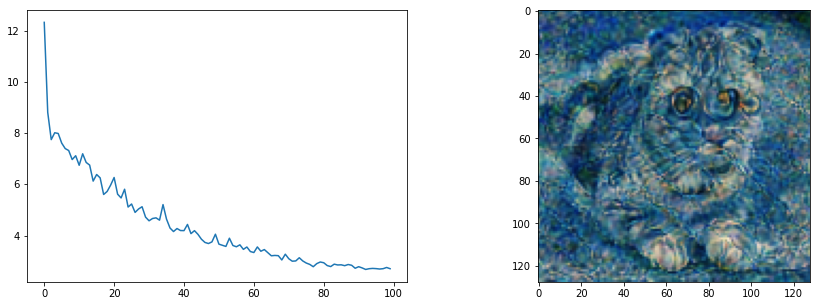

In [35]:
#@markdown **quick style transfer with gen = SirenGenerator():**
style_loss_fn = OTStyleLossToTarget(pil_to_tensor(style_image).to(device))
content_loss_fn = ContentLossToTarget(pil_to_tensor(content_image).to(device))
gen = SirenGenerator(size=128).to(device)
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01, weight_decay=1e-6)
losses = []
for i in tqdm(range(100)):
  output = gen()
  style_loss = style_loss_fn(output) # Try: adding a scaling factor here to weight this more heavily
  content_loss = content_loss_fn(output)
  loss = style_loss + content_loss
  if i % 25 == 0:
    print(f'Step: {i}: Loss: {loss.detach().item()} (style_loss {style_loss.detach().item()}, content_loss {content_loss.detach().item()})' )
  losses.append(loss.detach().item())
  optimizer.zero_grad() # Reset everything related to gradient calculations
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(losses)
axs[1].imshow(tensor_to_pil(gen()))

Again, something you can explore more soon!

## Final Generator: Bokeh! 

I'm going to show one final generator here as a demo of how you can get more creative with things like this. I wanted to make images with a small number of shapes, and while playing around got the idea of summing gaussians to get blurry blobs of different colours. 

What are the parameters? The location, color, intensity and size of eah blob.

How do we render this in a way that is differentiable? It's a little tricky, but to make it easier I did something to make any deep learning researcher cringe: I wrote a for loop. As in, `for each dot: ...` We don't like things like this because GPUs are good at doing things in parallel! But hacky as it is, it works! You don't have to do everything perfectly ;)

This code isn't itself very interesting or worth copying, but hopefully it does highlight the more general idea: hack things together and have fun!

Output shape: torch.Size([1, 3, 256, 256])
Parameter shapes: [torch.Size([2, 100]), torch.Size([100]), torch.Size([100]), torch.Size([3, 100]), torch.Size([100])]


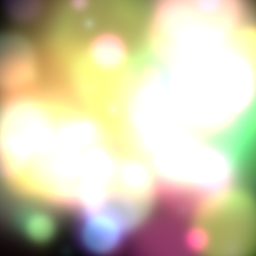

In [36]:
class DotGenerator(nn.Module):
  def __init__(self, n_points=100, size=256, device='cpu'):
    super(DotGenerator, self).__init__()

    # Set some attributes
    w, h = size, size # You can take both as args for non-square images
    self.n_points = n_points
    self.w = w
    self.h = h
    self.sig = nn.Sigmoid()
    self.device=device

    # A grid of x, y locations (from 0 to 1):
    gridy, gridx = torch.meshgrid(1-torch.arange(h)/h, torch.arange(w)/w, indexing='ij')
    self.grid = torch.stack([gridx, gridy]).to(device) # shape: (2, w, h)

    # The parameters for the points:
    self.coords = nn.Parameter(torch.rand((2, n_points))) # X and Y positions
    self.sizes = nn.Parameter(torch.rand(n_points)*10) # << Tweak for bigger or smaller dots
    self.falloffs = nn.Parameter((torch.rand(n_points)*100+0.2*100)) # << Tweak 0.2 and 100 to change look
    self.colors = nn.Parameter(torch.rand(3, n_points)) # RGB colours
    self.intensities = nn.Parameter(torch.rand(n_points)*3) # << Change 3 to change max brightness

    # The 'image' we'll draw to - RGB, same size as grid (w x h)
    self.canvas = torch.zeros_like(self.grid[0].expand(3, -1, -1)).to(device)

  def to_device(self, device):
    self.to(device)
    self.grid = self.grid.to(device)
    

  def forward(self):
    self.canvas = torch.zeros_like(self.canvas).to(self.device) # Zero out our canvas
    for i in range(self.n_points): # Iterating over points (not ideal!!)
      # Point attributes:
      r, g, b = self.colors[:,i]
      intensity = self.intensities[i]
      px, py = self.coords[:,i]
      size = self.sizes[i]
      falloff = self.falloffs[i]

      # Distance from each pixel to this point:
      dx, dy = torch.abs(self.grid[0]-px), torch.abs(self.grid[1]-py)
      dist = (dx**2 + dy**2)**0.5

      # Draw the point with intensity dropping as distance increases
      sig_dist = 1-self.sig(dist*falloff - size)
      self.canvas[0] += r*sig_dist*intensity
      self.canvas[1] += g*sig_dist*intensity
      self.canvas[2] += b*sig_dist*intensity

    return self.canvas.unsqueeze(0)/(0.5*self.n_points**0.5) # Scale the final result (this is approximate) 

# Create one with 100 blobs
d = DotGenerator(100)

gen = DotGenerator(size=256)
im = gen()
print(f'Output shape: {im.shape}')
print(f'Parameter shapes: {[p.shape for p in gen.parameters()]}')
tensor_to_pil(im)

You'll need to tweak parameters to keep the image looking nice with larger sizes or different numbers of dots, but at least this does roughly what we wanted. Inpecting the parameters you'll see we have a few for each dot (100 dots here):

In [37]:
gen = DotGenerator(size=256, device=device)
im = gen()
print(f'Output shape: {im.shape}')
print(f'Parameter shapes: {[p.shape for p in gen.parameters()]}')
im.device

Output shape: torch.Size([1, 3, 256, 256])
Parameter shapes: [torch.Size([2, 100]), torch.Size([100]), torch.Size([100]), torch.Size([3, 100]), torch.Size([100])]


device(type='cuda', index=0)

https://teia.art/sparkles_jw has examples of some animations made with this same idea...

## Final Loss: CLIP

OK, the final loss function is going to feel like a super-power. What if we want to just describe what we want in text?

Enter CLIP. Remember: CLIP maps images and text to the same space, so we can compare them. We'll load a CLIP model and test this for ourselves for a few mini demos before turning this into another loss function we can use to guide generation.

Text and image similarity (show use for one-shot classification and search)

Text or image (or multiple) as prompts

In [38]:
#@title some utilities
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cut_power=1.0): # TODO add augs
        super().__init__()

        self.cut_size = cut_size
        self.cut_power = cut_power

    def forward(self, pixel_values, num_cutouts):
        sideY, sideX = pixel_values.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(num_cutouts):
            size = int(torch.rand([]) ** self.cut_power * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = pixel_values[:, :, offsety : offsety + size, offsetx : offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def set_requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value

def clip_loss_embeddings(image_embed, target_embeds, weights=None):
  input_normed = F.normalize(image_embed.unsqueeze(1), dim=-1)
  embed_normed = F.normalize(target_embeds.unsqueeze(0), dim=-1)
  dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

In [39]:
#@title load a clip model

# A nice small model (B='base') - good for quick tests and smaller download:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

# A medium one (L='large'):
# clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='laion2b_s32b_b82k')

# A massive one (H='huge') that needs lots of RAM but might generate better images?:
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')


# print(preprocess)
preprocess = T.Compose([
    T.Resize(size=224, max_size=None, antialias=None),
    T.CenterCrop(size=(224, 224)),
    T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])
clip_model.to(device)

# We don't want to train CLIP at all so setting requires_grad=False everywhere
# Probably unnecessary but rather safe than sorry :)
clip_model.eval();
for p in clip_model.parameters():
  p.requires_grad = False

100%|███████████████████████████████████████| 605M/605M [01:43<00:00, 5.86MiB/s]


### Demo: One-shot classification

In [43]:
# Load an image
cat_im = pil_to_tensor(Image.open('cat.jpeg')).to(device)

# Encode the image with CLIP
image_embed = clip_model.encode_image(preprocess(cat_im))
print('Image embed shape:', image_embed.shape)

# Encode some labels with CLIP
tokenized_text = open_clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
target_embeds = clip_model.encode_text(tokenized_text)
print('Texts embed shape:',target_embeds.shape) # One for each label

# Find the similarity to each 
torch.nn.CosineSimilarity()(image_embed, target_embeds)

Image embed shape: torch.Size([1, 512])
Texts embed shape: torch.Size([3, 512])


tensor([0.1012, 0.1524, 0.2709], device='cuda:0')

We see a higher similarity for the label 'a cat' vs 'a dog' and 'a diagram' is the lowest'

We can flip this around to do image search. Given a load of images, we embed a text query and find the image that is the best match. This could be a fun exercise to try ;)

### Using it as a loss

We can look at the similarity between the CLIP embedding of a generated image and one or more CLIP embeddings of images or text we're feeding in as targets. 

Let's look at this in action:

In [44]:
# Create a generator and get an output im
gen = SirenGenerator(size=128).to(device)
gen.to(device)
im = gen()

# Embed this with CLIP
with torch.no_grad():
  image_embed = clip_model.encode_image(preprocess(im))
print(image_embed.shape)

# Embed some target texts
with torch.no_grad():
  tokenized_text = open_clip.tokenize(["a blue cat", "A cat picture"]).to(device)
  target_embeds = clip_model.encode_text(tokenized_text)
print(target_embeds.shape)

# I wrote clip_loss_embeddings to take an image embed and multiple target embeds,
# and return the average loss across the different targets:
clip_loss_embeddings(image_embed, target_embeds)

torch.Size([1, 512])
torch.Size([2, 512])


tensor(1.0638, device='cuda:0')

### Making our neat loss class

It helps to make multiple variations of the generated image so CLIP doesn't see the exact same thing each time - hence the make_cutouts bit here. More cutouts => cleaner loss signal but more memory usage. You can explore this or just go with the defaults.

In [45]:
class CLIPLossToTargets(nn.Module):
  """ Gram matrix based style loss"""
  def __init__(self, text_prompts=[], image_prompts=[], n_cuts=16):
    super(CLIPLossToTargets, self).__init__()
    self.target_embeds = []
    with torch.no_grad():
      for text_prompt in text_prompts:
        tokenized_text = open_clip.tokenize([text_prompt]).to(device)
        self.target_embeds.append(clip_model.encode_text(tokenized_text))
      for image_prompt in image_prompts:
        image_embed = clip_model.encode_image(preprocess(im))
        self.target_embeds.append(image_embed)

    self.target_embeds = torch.cat(self.target_embeds) # All the target embeddings

    self.n_cuts = n_cuts
    if self.n_cuts > 1:
      self.make_cutouts = MakeCutouts(224)
      

  def forward(self, input):
    if self.n_cuts > 1:
      input = self.make_cutouts(input, num_cutouts=self.n_cuts)
    input_embed = clip_model.encode_image(preprocess(input))
    return clip_loss_embeddings(input_embed, self.target_embeds)

# Testing...
clip_loss_fn = CLIPLossToTargets(text_prompts=['A cat'], image_prompts=[im])
clip_loss_fn(torch.rand(1, 3, 64, 64).to(device))

tensor(0.5867, device='cuda:0')

OK - we're ready to try it!

# Your Turn!

I've made a little function for you that takes a generator, a list of losses (and optional weights for each) and some extra parameters and optimises the parameters of the generator for a given number of steps.

Your task: play around combining the different building blocks we made today, and add some of your own! Perhaps a loss that encourages a specific average color, or a generator that just tweaks the hue and brightness of an input image. 

In [46]:
#@markdown convenience function: optimise(gen, loss_functions, n_steps=100, optimizer=None, loss_weights=None, save_previews=True, display_every=10, save_every=10)
import os
from fastprogress.fastprogress import master_bar, progress_bar

def optimise(gen, loss_functions, n_steps=100, optimizer=None, loss_weights=None, save_previews=True, display_every=10, save_every=10):
  
  # The optimizer (defaults to Adam)
  if optimizer == None:
    optimizer = torch.optim.Adam(gen.parameters(), lr=0.01, weight_decay=1e-6)

  # The loss weights
  if loss_weights == None:
    loss_weights = [1 for _ in loss_functions]

  # Make an empty folder to save steps
  os.system('rm -rf steps/')
  os.system('mkdir steps/')

  losses = [] # Keep track of our losses

  # Some fancier progress bar stuff
  mb = master_bar(range(1))
  mb.names=['loss']
  mb.graph_fig, axs = plt.subplots(1, 2, figsize=(15, 5)) # For custom display
  mb.graph_ax = axs[0]
  mb.img_ax = axs[1]
  mb.graph_out = display(mb.graph_fig, display_id=True)

  for p in mb:
    for i in progress_bar(range(n_steps), parent=mb):
      # Get the generator output
      output = gen()

      # Calculate our loss
      loss = 0

      for idx, loss_fn in enumerate(loss_functions):
        loss += loss_fn(output) * loss_weights[idx]

      # Store the loss for later
      losses.append(loss.detach().item())

      # View every 5 iterations
      if i % display_every == 0:
        # Show progress and loss plot
        mb.update_graph([[range(len(losses)), losses]])
        # Update image:
        img = tensor_to_pil(output)
        mb.img_ax.imshow(img)
        mb.graph_out.update(mb.graph_fig)
      

      # Save the output occasionally
      if i % save_every == 0:
        tensor_to_pil(output).save(f'steps/{i//save_every:05}.jpeg')

      # Backpropagate the loss and use it to update the parameters
      optimizer.zero_grad() # Reset everything related to gradient calculations
      loss.backward() # This does all the gradient calculations
      optimizer.step() # The optimizer does the update

EG: A single loss function + generator:

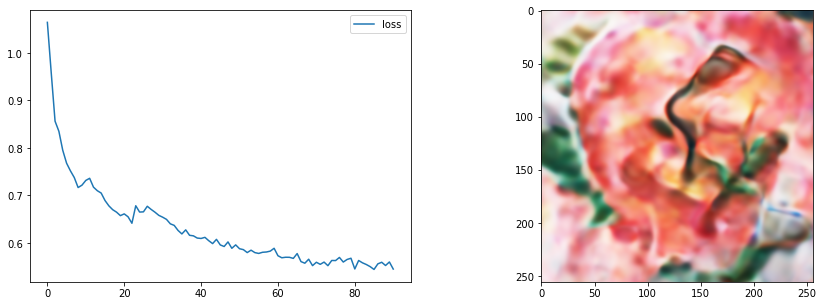

In [47]:
# EG1 SIREN + CLIP
gen = SirenGenerator().to(device)
clip_loss_fn = CLIPLossToTargets(text_prompts=['A watercolor painting of a rose'])
optimise(gen, [clip_loss_fn])

We only update the image display every `display_every` steps to save time. Images are also saved to steps/ every `save_every` steps - nice if you want to make a video showing the process or something. Set this to 1000 or something to skip that part (makes things a little faster).

Combining multiple loss functions:

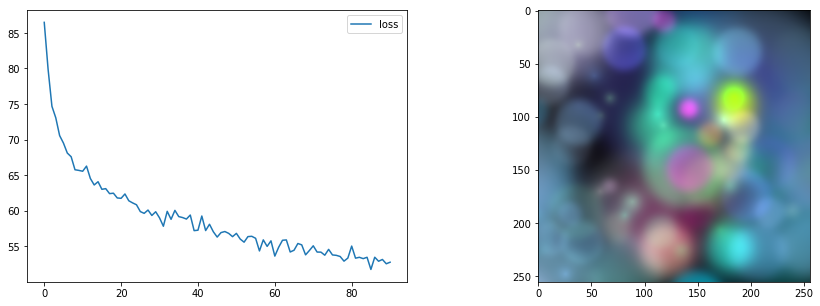

In [48]:
#@markdown EG2 Style + content loss with DotGenerator
gen = DotGenerator(size=256, device=device)
style_loss_fn = OTStyleLossToTarget(pil_to_tensor(style_image).to(device))
content_loss_fn = ContentLossToTarget(pil_to_tensor(content_image).to(device))
loss_functions = [style_loss_fn, content_loss_fn]
loss_weights = [1, 15] # More weight on the content loss
optimise(gen, loss_functions, loss_weights=loss_weights, save_every=1000)

Getting more specific with the different components:

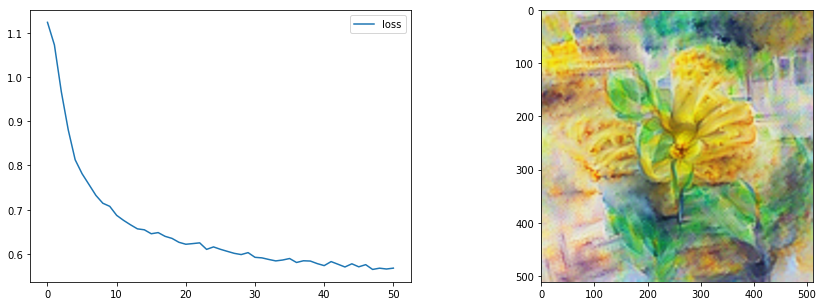

In [49]:
#@markdown EG3 More control

# Parameters of the imstack tweaked
gen = ImStackGenerator(size=512,base_size=8,n_layers=3,scale=4,layer_decay = 0.3).to(device)

# A custom optimiser
opt = torch.optim.AdamW(gen.parameters(), lr=0.05, 
                       weight_decay=1e-4) # Weight decay for less extreme values

# Loss function
clip_loss_fn = CLIPLossToTargets(text_prompts=['A watercolor painting of a yellow flower'],
                                 n_cuts=64) # More cuts for smoother loss signal

# Tweak number of steps and use our custom optimiser
optimise(gen, loss_functions=[clip_loss_fn],
         optimizer=opt, n_steps=60)

## Ideas

- Can you get cool-looking images with a really small SIREN network?
- Can you get a nice-looking style transfer demo working?
- Can you implement a loss function that forces a specific palette of colours? Or a color gradient across the image?
- Can you chain these, first optimising towards one target then another (hint: just re-use a generator and call optimise again with different loss functions!). For eg SIREN to an image (via MSE) then to a CLIP prompt to tweak it.
- Advanced: Can you add new generators? One based on 'Deep Image Priors' perhaps, or using something like VQGAN and optimizing the latents which are then decoded by the VQGAN decoder to get an output image.
- Can you think of a loss that would avoid noisy images? Hint: look up 'TV Loss'
- How about a loss that penalizes over-saturated colours?
- How about a generator that can only make black and white images?
- How would you make a generator that created 'seamless' images to use in combination with CLIP? 
- Advanced: What about using PyTorch3D's differentiable rendering to optimise the vertices of a shape or the texture of a 3d model to match a style or CLIP prompt?


Anyway, that's that! Feel free to reach me @johnowhitaker with questions, bugs, feedback or to chat about all things generative :)